In [196]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib as mpl
import pingouin as pg
from statsmodels.stats.power import TTestIndPower, FTestAnovaPower

In [3]:
#Import Data
betes_dat=pd.read_csv('/Users/benkelly/Downloads/diabetes (2).csv')

# Inspection

In [4]:
#Check out data types, dataaframe shape, and nulls
betes_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
#Double check for any null values
betes_dat.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
betes_dat.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

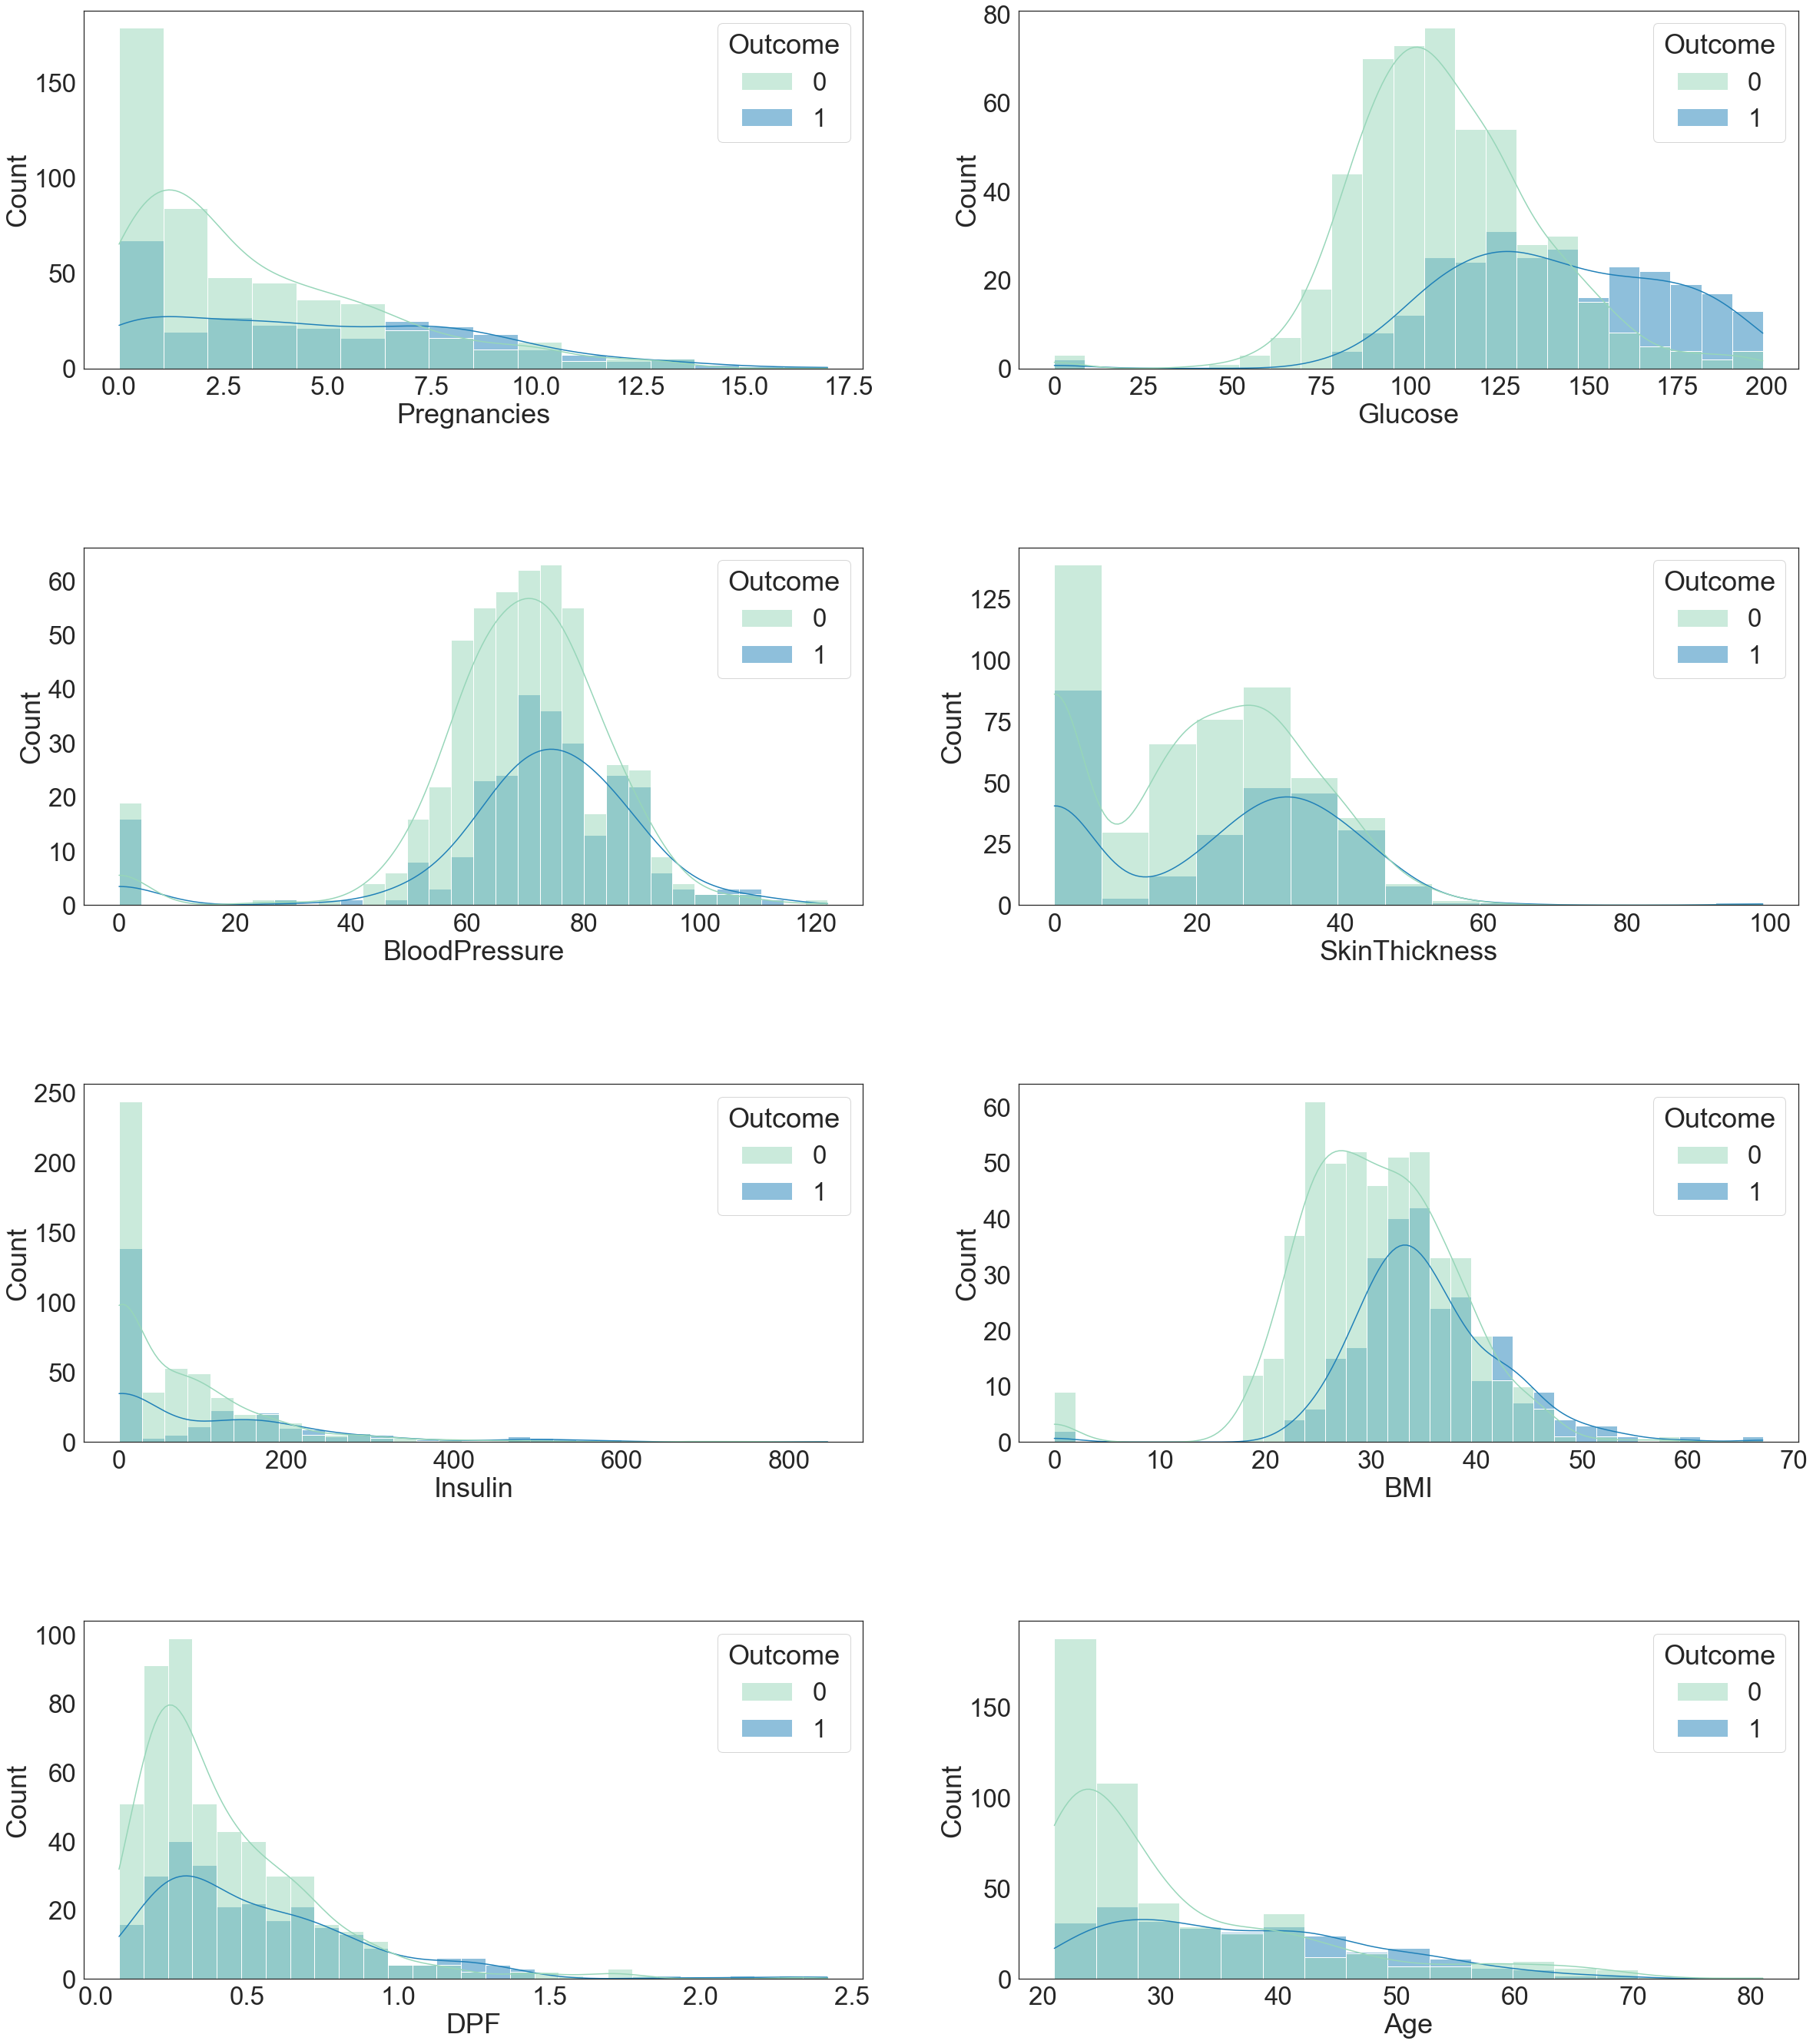

In [7]:
#Histograms
betes_dat.rename(columns={'DiabetesPedigreeFunction':'DPF'}, inplace=True)

feature_names = [cname for cname in betes_dat.loc[:,:'Age'].columns]
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=betes_dat, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

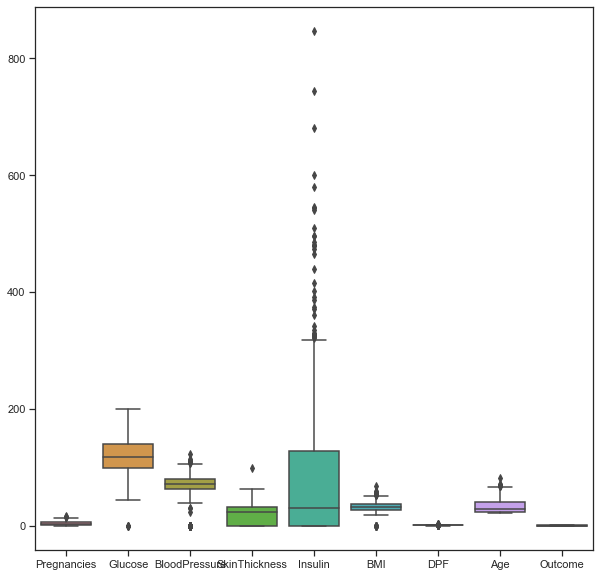

In [8]:
#BoxPlot to show outliers 
sns.set_theme(style="ticks", palette="YlGnBu")
fig , ax = plt.subplots(figsize = (10,10))
sns.boxplot(data = betes_dat, ax = ax)
sns.set(font_scale = 1)

Generally normal distributions. Pregnancies, DPF, and Age are closer to Poisson. Generally positively skewed

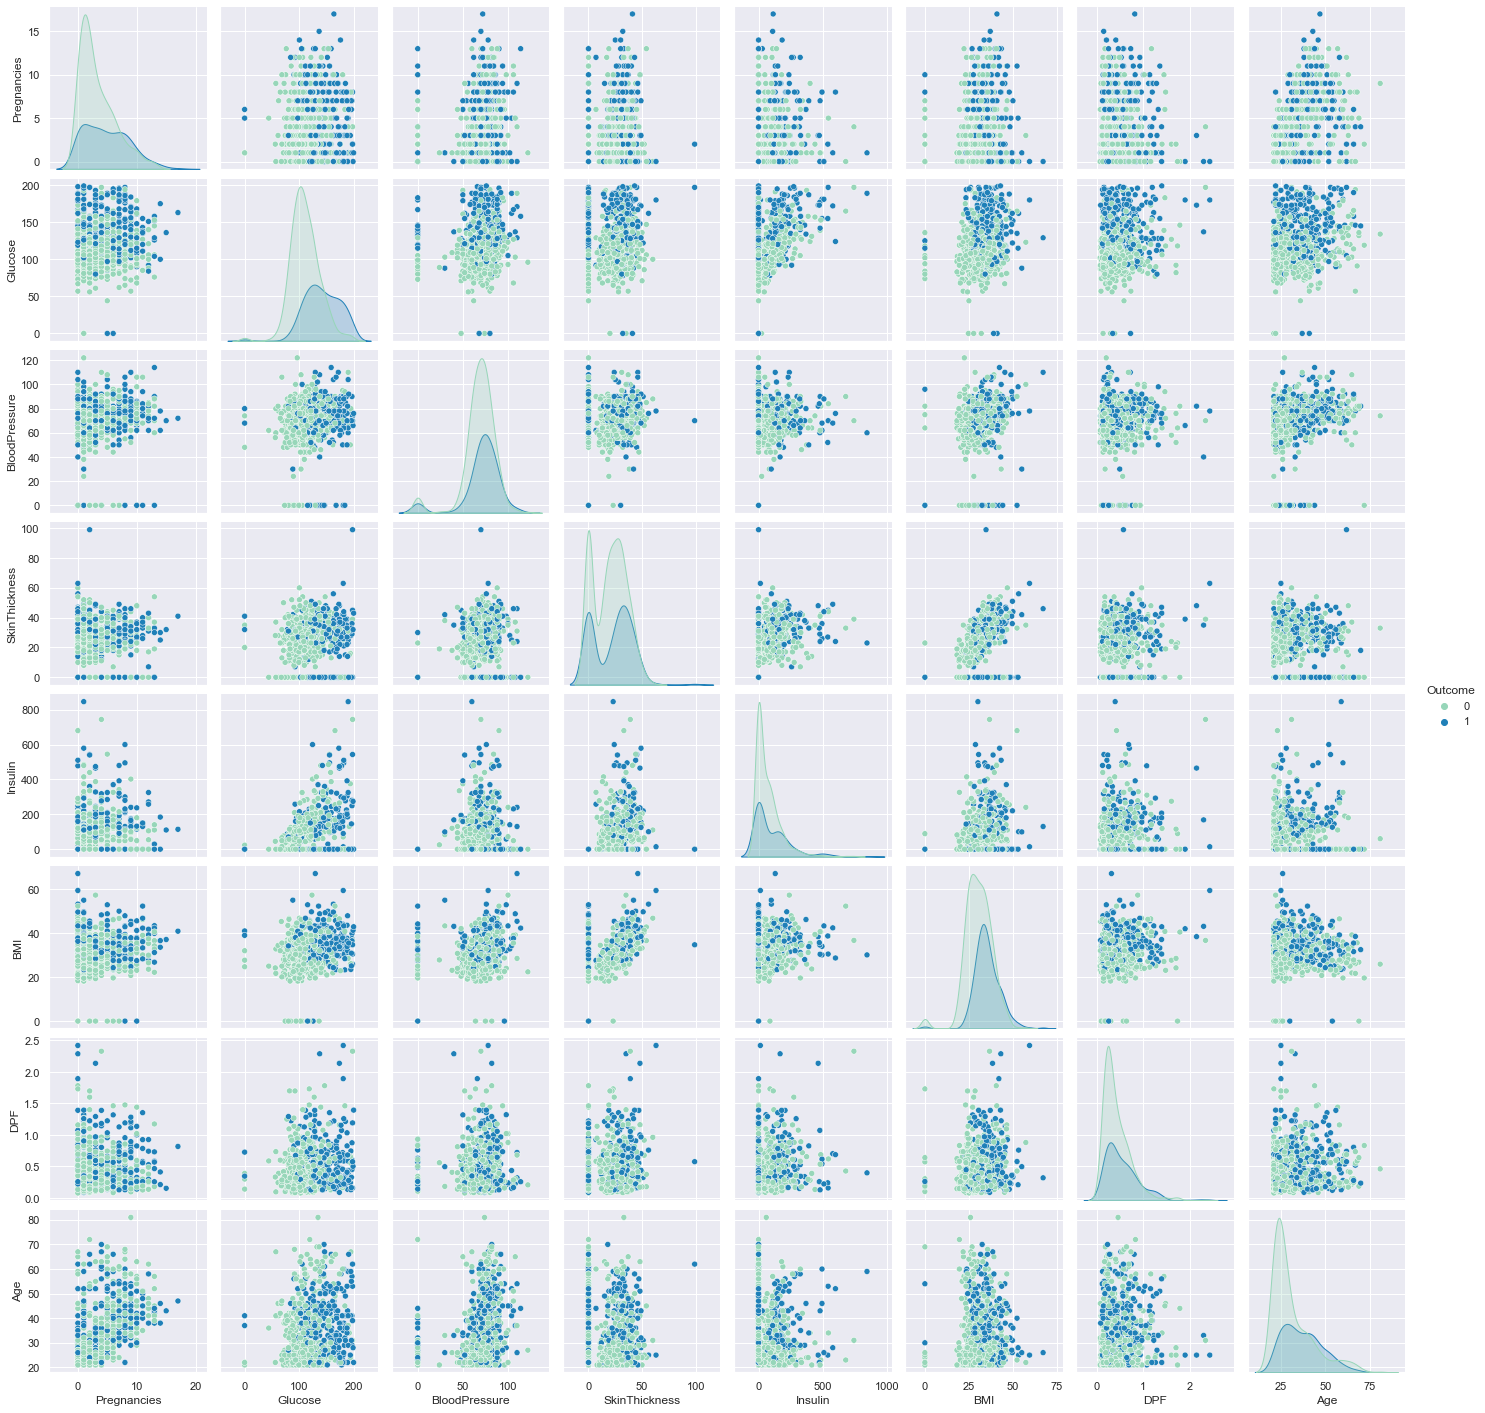

In [9]:
# Scatter Plots
sns.pairplot(betes_dat, hue="Outcome", palette="YlGnBu")

### Is this data Tidy?
EVERY COLUMN IS A VARIABLE: Yes, different biological measures.
EVERY ROW IS AN OBSERVATION: Yes, each row is one individual in the dataset.
EVERY CELL IS A VALUE: Yes, measure of each measure per individual.

The data is Tidy.

# Cleaning

In [10]:
#Check for columns with values of 0 (not )
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DPF','Age']
total_count = betes_dat['Outcome'].count()

for feature in zero_features:
    zero_count = betes_dat[betes_dat[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, {2}%'.format(feature, zero_count, int(100*zero_count/total_count)))

Pregnancies 0 number of cases 111, 14%
Glucose 0 number of cases 5, 0%
BloodPressure 0 number of cases 35, 4%
SkinThickness 0 number of cases 227, 29%
Insulin 0 number of cases 374, 48%
BMI 0 number of cases 11, 1%
DPF 0 number of cases 0, 0%
Age 0 number of cases 0, 0%


0 pregnancies make sense, but all the other 0's are more suspicious. 
Blood Pressure and BMI should not be 0, that would mean death, so replace with median values.
Based on research skin thickness can not be 0, so I will also replace those with the median.

Test if insulin has any relationship to Outcome (will not be my final hypothesis).Strong relationship to diabetes. Research has found that previously thought levels of 0 insulin may just not have been tested with precise methods. This means 0 Insulin measures aer

In [11]:
df=betes_dat.copy()

In [12]:
#Replace 0's with Nan's
df[['Glucose','BloodPressure','BMI']] = df[['Glucose','BloodPressure','BMI']].replace(0, np.NaN)

In [13]:
# The missing values will be filled with the median values of each variable.

def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [14]:
#Fill Glucose 0's
var='Glucose'
out=median_target(var)
df.loc[(df['Outcome'] == 0 ) & (df[var].isnull()), var] = out.iloc[0][1]
df.loc[(df['Outcome'] == 1 ) & (df[var].isnull()), var] = out.iloc[1][1]

#Fill BP 0's
var='BloodPressure'
out=median_target(var)
df.loc[(df['Outcome'] == 0 ) & (df[var].isnull()), var] = out.iloc[0][1]
df.loc[(df['Outcome'] == 1 ) & (df[var].isnull()), var] = out.iloc[1][1]

#Fill BMI 0's
var='BMI'
out=median_target(var)
df.loc[(df['Outcome'] == 0 ) & (df[var].isnull()), var] = out.iloc[0][1]
df.loc[(df['Outcome'] == 1 ) & (df[var].isnull()), var] = out.iloc[1][1]

In [15]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.677083      72.389323      20.536458   79.799479   
std       3.369578   30.464161      12.106039      15.952218  115.244002   
min       0.000000   44.000000      24.000000       0.000000    0.000000   
25%       1.000000   99.750000      64.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI         DPF         Age     Outcome  
count  768.000000  768.000000  768.000000  768.000000  
mean    32.434635    0.471876   33.240885    0.348958  
std      6.880498    0.331329   11.760232    0.476951  
min     18.200000    0.078000   21.000000    0.000000  
25%     27.500000    0.243750   24.000000    0.000000  
50%     32.050000    0.372500   29.000000    0.000000  
75%     36.600000    0.626250   41.000000    1.000000  
max     67.100000    2.420000   81.000000    1.000000

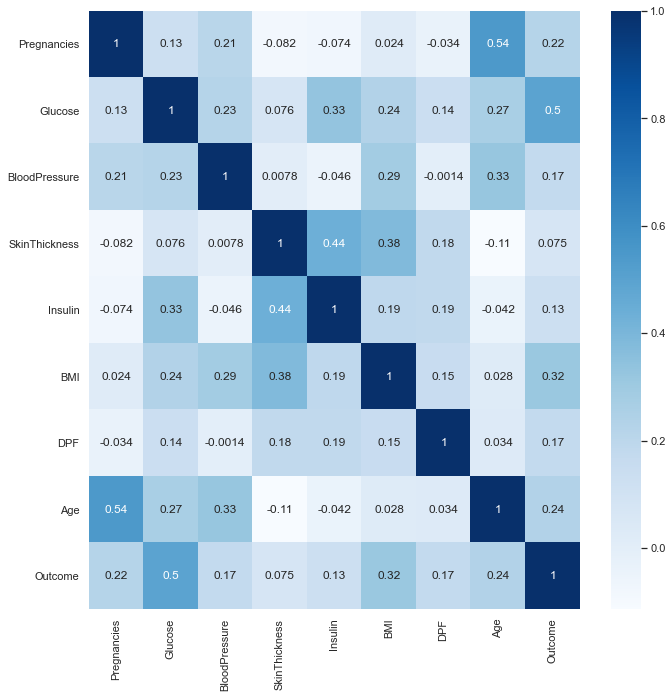

In [16]:
figsns=plt.figure(3,figsize=(11,11))

sns.heatmap(df.corr(),annot=True,cmap='Blues')

plt.show()

# Binning

In [17]:
#Age binning following (Petry, 2002)
def age_to_age_bin(row):
    if 21 <= row["Age"] < 30:
        return "1-Young Adult"
    elif 30 <= row["Age"] < 65:
        return "2-Middle Age"
    else:
        return "3-Older Adult"


# Binning based on (Health Canada, 2010)
def bmi_to_bmi_bin(row):
    if row["BMI"] < 18.5:
        return "1-Underweight"
    elif row["BMI"] < 24.9:
        return "2-Normal"
    elif row["BMI"] < 29.9:
        return "3-Overweight"
    elif row["BMI"] >= 29.9:
        return "4-Obese"
    else:
        return None

In [18]:
#Apply binning
df["AgeBins"] = df.apply(age_to_age_bin, axis=1)
#df["BloodPressureGroup"] = df.apply(blood_pressure_to_blood_pressure_group, axis=1) Can bin BP for later analysis
df["BMIBins"] = df.apply(bmi_to_bmi_bin, axis=1)

In [19]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.677083      72.389323      20.536458   79.799479   
std       3.369578   30.464161      12.106039      15.952218  115.244002   
min       0.000000   44.000000      24.000000       0.000000    0.000000   
25%       1.000000   99.750000      64.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI         DPF         Age     Outcome  
count  768.000000  768.000000  768.000000  768.000000  
mean    32.434635    0.471876   33.240885    0.348958  
std      6.880498    0.331329   11.760232    0.476951  
min     18.200000    0.078000   21.000000    0.000000  
25%     27.500000    0.243750   24.000000    0.000000  
50%     32.050000    0.372500   29.000000    0.000000  
75%     36.600000    0.626250   41.000000    1.000000  
max     67.100000    2.420000   81.000000    1.000000

#### Create Dummy Variables for Shapiro and Linear Regression Later

In [20]:
df['AgeDums'] = df['AgeBins'].map({'1-Young Adult':1,  '2-Middle Age':2,'3-Older Adult':3})
df['BMIDums'] = df['BMIBins'].map({'1-Underweight':1, '2-Normal':2,'3-Overweight':3,'4-Obese':4})

[(20.0, 140.0)]

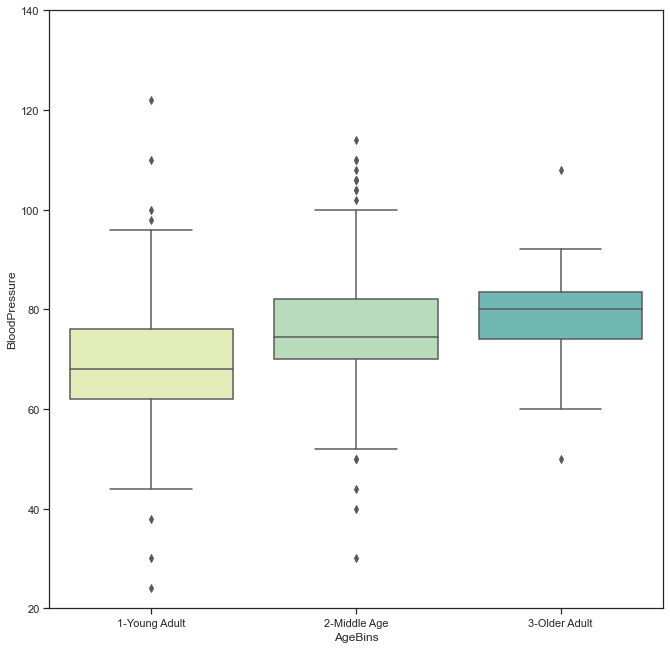

In [21]:
# Boxplot of Age bins vs Blood Pressure
sns.set_theme(style="ticks", palette="YlGnBu")
figsns=plt.figure(3,figsize=(11,11))
ax = sns.boxplot(x="AgeBins", y="BloodPressure", data=df, order=['1-Young Adult','2-Middle Age','3-Older Adult'])

# Limit y-axis
ax.set(ylim=(20, 140))

[(20.0, 140.0)]

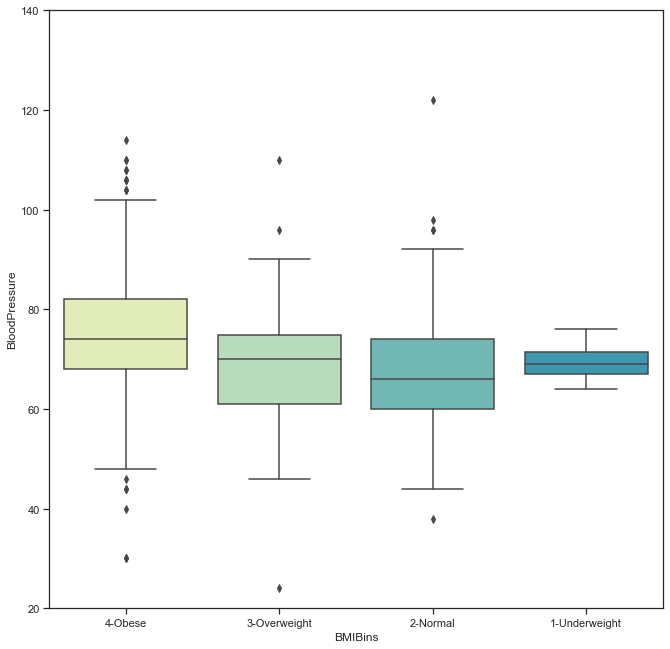

In [22]:
# Boxplot of BMI bins vs Blood Pressure
figsns=plt.figure(3,figsize=(11,11))
ax = sns.boxplot(x="BMIBins", y="BloodPressure", data=df)

# Limit y-axis
ax.set(ylim=(20, 140))

In [23]:
df['AgeBins'].value_counts()

1-Young Adult    396
2-Middle Age     356
3-Older Adult     16
Name: AgeBins, dtype: int64

In [25]:
df['BMIBins'].value_counts()

4-Obese          488
3-Overweight     175
2-Normal         101
1-Underweight      4
Name: BMIBins, dtype: int64

Older adults and underweight individuals are relatively underrepresented in the data.

# Assumption Testing

### Shapiro-Wilks

In [26]:
#Shapiro-Wilks Test of Normality
stat, pvalue = stats.shapiro(df['Pregnancies'])
print('Pregnancies - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['Glucose'])
print('Glucose - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['BloodPressure'])
print('BloodPressure - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['SkinThickness'])
print('SkinThickness - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['Insulin'])
print('Insulin - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['BMI'])
print('BMI - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['DPF'])
print('DPF - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['Age'])
print('Age - Test Stat: ', stat,' p-value:',pvalue)

Pregnancies - Test Stat:  0.9042782783508301  p-value: 1.6080885881590613e-21
Glucose - Test Stat:  0.9697533249855042  p-value: 1.6375369810139873e-11
BloodPressure - Test Stat:  0.9882556200027466  p-value: 7.92563059803797e-06
SkinThickness - Test Stat:  0.90462726354599  p-value: 1.75157635361056e-21
Insulin - Test Stat:  0.7220207452774048  p-value: 7.915248149269491e-34
BMI - Test Stat:  0.9791935682296753  p-value: 5.41224309813515e-09
DPF - Test Stat:  0.8365186452865601  p-value: 2.477696547502535e-27
Age - Test Stat:  0.8747662305831909  p-value: 2.401946561183188e-24


None are normal, but fine considering sample size.

In [27]:
#Dummy Shapiros
stat, pvalue = stats.shapiro(df['AgeDums'])
print('AgeBins - Test Stat: ', stat,' p-value:',pvalue)
stat, pvalue = stats.shapiro(df['BMIDums'])
print('BMIBins - Test Stat: ', stat,' p-value:',pvalue)

AgeBins - Test Stat:  0.6905151605606079  p-value: 3.1340381219460363e-35
BMIBins - Test Stat:  0.6831753253936768  p-value: 1.5345312497563895e-35


New dummy bins are still non-normal.

### Levene's Tests

In [28]:
#BloodPressure and Age
from bioinfokit.analys import stat
res = stat()
res.levene(df=df, res_var='BloodPressure', xfac_var='Age')
res.levene_summary

Parameter    Value
0      Test statistics (W)   0.9562
1  Degrees of freedom (Df)  51.0000
2                  p value   0.5625

In [29]:
#BloodPressure and Age Bins
res = stat()
res.levene(df=df, res_var='BloodPressure', xfac_var='AgeBins')
res.levene_summary

Parameter   Value
0      Test statistics (W)  0.8485
1  Degrees of freedom (Df)  2.0000
2                  p value  0.4285

In [30]:
#BloodPressure and BMI
res = stat()
res.levene(df=df, res_var='BloodPressure', xfac_var='BMI')
res.levene_summary

Parameter     Value
0      Test statistics (W)    1.1201
1  Degrees of freedom (Df)  246.0000
2                  p value    0.1455

In [31]:
#BloodPressure and BMI Bins
res = stat()
res.levene(df=df, res_var='BloodPressure', xfac_var='BMIBins')
res.levene_summary

Parameter   Value
0      Test statistics (W)  0.9492
1  Degrees of freedom (Df)  3.0000
2                  p value  0.4163

In [32]:
#Age and BMI
res = stat()
res.levene(df=df, res_var='Age', xfac_var='BMI')
res.levene_summary

Parameter     Value
0      Test statistics (W)    0.6771
1  Degrees of freedom (Df)  246.0000
2                  p value    0.9997

In [29]:
#Age and BMI Bins
#Can not find variance between two categorical variables.
#res = stat()
#res.levene(df=df, res_var='AgeBins', xfac_var='BMIBins')
#res.levene_summary

All variables have equal variance as we accept the null hypothesis in all Levene's tests.

### MultiColinearity 

In [184]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# identifying independent variables
independent_variables = df[['Insulin', 'BMI', 'SkinThickness', 'DPF',
                                  'Glucose', 'Age', 'Pregnancies', 'Outcome']]

# Make VIF data
vif_data = pd.DataFrame()
vif_data["variable"] = independent_variables.columns
  
# calculating VIF for each ind. variable
vif_data["VIF"] = [variance_inflation_factor(independent_variables.values, i)
                          for i in range(len(independent_variables.columns))]
  
vif_data

variable        VIF
0        Insulin   2.055429
1            BMI  18.490090
2  SkinThickness   3.877996
3            DPF   3.234089
4        Glucose  19.892150
5            Age  12.701923
6    Pregnancies   3.365027
7        Outcome   1.881090

# T-tests

In [54]:
tStat, pValue = stats.ttest_ind( df['Age'],df['BloodPressure'])
print("Age X BP P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

tStat, pValue = stats.ttest_ind(df['BMI'],df['BloodPressure'])
print("BMI X BP P-Value:{0} T-Statistic:{1}".format(pValue,tStat))

tStat, pValue = stats.ttest_ind(df['BMI'],df['Age'])
print("BMI X Age P-Value:{0} T-Statistic:{1}".format(pValue,tStat))


Age X BP P-Value:0.0 T-Statistic:-64.28059615368309
BMI X BP P-Value:0.0 T-Statistic:-79.51742692680928
BMI X Age P-Value:0.10123714230314101 T-Statistic:-1.6398704229939216


Ttest_indResult(statistic=-64.28059615368309, pvalue=0.0)

Both proposed predictor variables correlate with Blood pressure, but not with eachother at a significant p-value of 0.05. 0.0 is significant as the code does not have the capacity present the many digits required.

In [128]:
#Finding effect sizes and power (two-way alternative hypothesis)
#BP and Age
pg.ttest(df['BloodPressure'],df['Age'],  paired=False)

T   dof alternative  p-val           CI95%   cohen-d BF10  \
T-test  64.280596  1534   two-sided    0.0  [37.95, 40.34]  3.280305  inf   

        power  
T-test    1.0

In [174]:
#BP and BMI
pg.ttest(df['BloodPressure'],df['BMI'], paired=False)

T   dof alternative  p-val           CI95%   cohen-d BF10  \
T-test  79.517427  1534   two-sided    0.0  [38.97, 40.94]  4.057857  inf   

        power  
T-test    1.0

In [132]:
#Age and BMI
pg.ttest(df['Age'],df['BMI'], paired=False)

T   dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.63987  1534   two-sided  0.101237  [-0.16, 1.77]  0.083684  0.217   

           power  
T-test  0.374219

# Power Analysis

In [85]:
# Parameters for our power analysis
effect_size = 0.8 #Considered a large effect size (meaning we'd expect a large effect size)
alpha = 0.05 #Standard academic significance level
power = 0.8 #Standard aceptable power

# Run power analysis for sample t-test
analysis = TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size Needed:', result)

Sample Size Needed: 25.52457250047935


Running a preliminary power analysis while aiming for standard academic metrics shows we would need a sample size of 26 to run appropriate statistical tests. Luckily, our dataset has 768 instances. 

   Effect Size  Alpha  Power  Sample Size
0          0.2   0.05    0.8   393.405699
1          0.3   0.05    0.8   175.384672
2          0.4   0.05    0.8    99.080327
3          0.5   0.05    0.8    63.765612
4          0.6   0.05    0.8    44.585790
5          0.7   0.05    0.8    33.024570
6          0.8   0.05    0.8    25.524573
7          0.9   0.05    0.8    20.386331


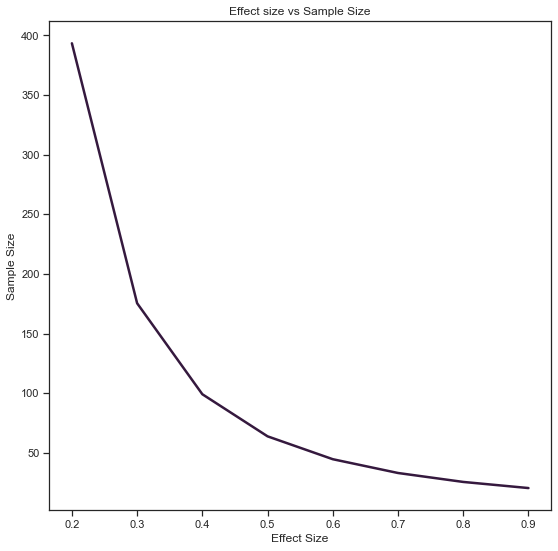

In [105]:
#Changing effect sizes on sample size
effect_size = np.arange(0.2, 1, 0.1)
alpha = 0.05
power = 0.8

def power_analysis_func(row):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=row["Effect Size"], power=power, nobs1=None, ratio=1.0, alpha=alpha)

effsizes_df = pd.DataFrame({"Effect Size": effect_size, "Alpha": alpha, "Power": power})
effsizes_df["Sample Size"] = effsizes_df.apply(power_analysis_func, axis=1)
print(effsizes_df)
sns.set_theme(style="ticks", palette="rocket")
fig , ax = plt.subplots(figsize = (9,9))
ax = sns.lineplot(data=effsizes_df, x="Effect Size", y="Sample Size",palette='DarkRed', linewidth=2.5)
ax.set_title("Effect size vs Sample Size")
plt.show()

As studied effect size goes up, the required sample size decreases. 

   Effect Size  Alpha  Sample Size     Power
0          0.2   0.05           80  0.241758
1          0.3   0.05           80  0.470512
2          0.4   0.05           80  0.710370
3          0.5   0.05           80  0.881602
4          0.6   0.05           80  0.964976
5          0.7   0.05           80  0.992660
6          0.8   0.05           80  0.998925
7          0.9   0.05           80  0.999891


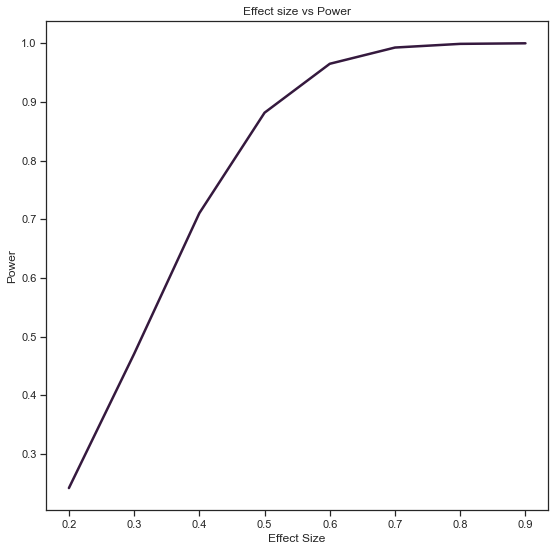

In [109]:
#Changing effect sizes on power
effect_size = np.arange(0.2, 1, 0.1)
alpha = 0.05
sample = 80

def power_analysis_func(row):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=row["Effect Size"], power=None, nobs1=sample, ratio=1.0, alpha=alpha)

effsvspower_df = pd.DataFrame({"Effect Size": effect_size, "Alpha": alpha, "Sample Size": sample})
effsvspower_df["Power"] = effsvspower_df.apply(power_analysis_func, axis=1)
print(effsvspower_df)
sns.set_theme(style="ticks", palette="rocket")
fig , ax = plt.subplots(figsize = (9,9))
ax = sns.lineplot(data=effsvspower_df, x="Effect Size", y="Power",palette='DarkRed', linewidth=2.5)
ax.set_title("Effect size vs Power")
plt.show()

As effect size increases, power increases.

In [112]:
# Plotting Power
sample = np.arange(10, 200, 25)
alpha = 0.05
effect_size = 0.8

def power_analysis_func(row):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=effect_size, power=None, nobs1=sample, ratio=1.0, alpha=alpha)

powers_df = pd.DataFrame({"Sample Size": sample, "alpha": alpha, "Effect size": effect_size})
powers_df["Power"] = powers_df.apply(power_analysis_func, axis=1)
powers_df

Sample Size  alpha  Effect size  \
0           10   0.05          0.8   
1           35   0.05          0.8   
2           60   0.05          0.8   
3           85   0.05          0.8   
4          110   0.05          0.8   
5          135   0.05          0.8   
6          160   0.05          0.8   
7          185   0.05          0.8   

                                               Power  
0  [0.39506921080684754, 0.9097226334799198, 0.99...  
1  [0.39506921080684754, 0.9097226334799198, 0.99...  
2  [0.39506921080684754, 0.9097226334799198, 0.99...  
3  [0.39506921080684754, 0.9097226334799198, 0.99...  
4  [0.39506921080684754, 0.9097226334799198, 0.99...  
5  [0.39506921080684754, 0.9097226334799198, 0.99...  
6  [0.39506921080684754, 0.9097226334799198, 0.99...  
7  [0.39506921080684754, 0.9097226334799198, 0.99...

In [160]:
# Parameters for our power analysis
sample = np.arange(10, 200, 25)
alpha = 0.05
effect_size = 0.8

def power_analysis_func(row):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=effect_size, power=None, nobs1=row["Sample"], ratio=1.0, alpha=alpha)

powers_df = pd.DataFrame({"Sample": sample_size, "alpha": alpha, "Effect size": effect_size})
powers_df["Power"] = powers_df.apply(power_analysis_func, axis=1)
powers_df

Sample  alpha  Effect size     Power
0      10   0.05          0.8  0.395069
1      35   0.05          0.8  0.909723
2      60   0.05          0.8  0.991481
3      85   0.05          0.8  0.999371
4     110   0.05          0.8  1.000000
5     135   0.05          0.8  1.000000
6     160   0.05          0.8  1.000000
7     185   0.05          0.8  1.000000

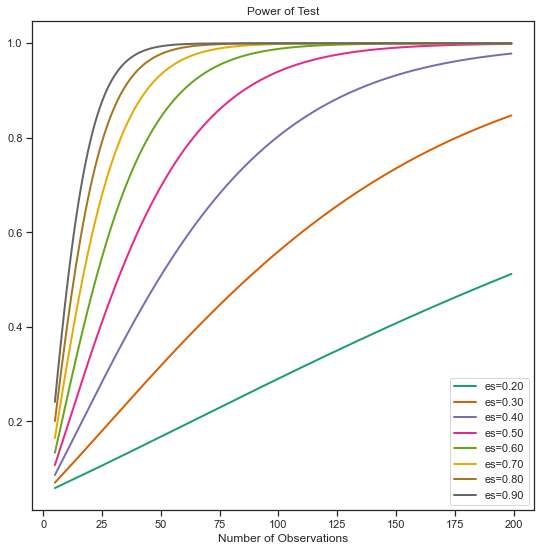

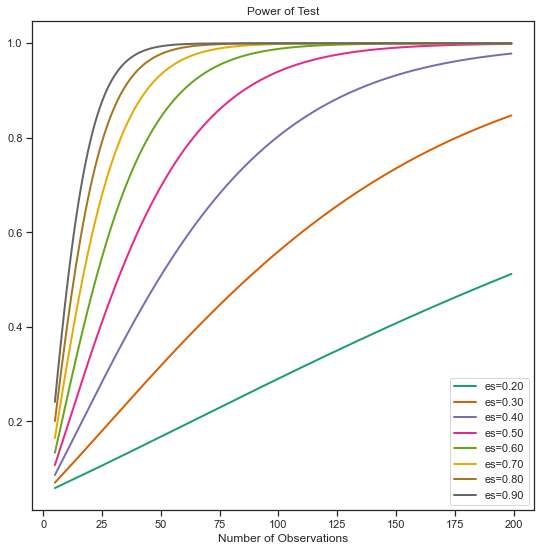

In [195]:
# Parameters for power analysis
effect_sizes = np.arange(0.2, 1, 0.1)
sample_sizes = np.arange(5, 200)
# calculate power curves from multiple power analyses
fig , ax = plt.subplots(figsize = (9,9))
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes, ax=ax)

In [171]:
#Minimum effect size detectable with given sample size TTest
analysis.solve_power(effect_size=None, power=0.8, nobs1=768, alpha=0.05)

0.1430569133728693

In [200]:
#Age Groups
FTestAnovaPower().solve_power(effect_size = None,power=0.8, nobs = 768, alpha = 0.05, k_groups= 3)

0.11222480543062247

In [201]:
#BMI Groups
FTestAnovaPower().solve_power(effect_size = None,power=0.8, nobs = 768, alpha = 0.05, k_groups= 4)

0.11945216166869915

# ANOVA's

### One-Way ANOVA's

In [63]:
#Age X BP ONE-WAY ANOVA
model = ols('BloodPressure ~ AgeBins', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq     df          F        PR(>F)
AgeBins     9768.287006    2.0  36.402559  7.912213e-16
Residual  102640.305442  765.0        NaN           NaN

In [64]:
#### TukeyHSD with Bonferoni Correction
pair_t = model.t_test_pairwise('AgeBins')
pair_t.result_frame

coef   std err         t         P>|t|  \
2-Middle Age-1-Young Adult    6.928470  0.845989  8.189790  1.094865e-15   
3-Older Adult-1-Young Adult  10.286616  2.953720  3.482597  5.247783e-04   
3-Older Adult-2-Middle Age    3.358146  2.960157  1.134449  2.569617e-01   

                             Conf. Int. Low  Conf. Int. Upp.     pvalue-hs  \
2-Middle Age-1-Young Adult         5.267735         8.589205  3.284594e-15   
3-Older Adult-1-Young Adult        4.488258        16.084974  1.049281e-03   
3-Older Adult-2-Middle Age        -2.452849         9.169141  2.569617e-01   

                             reject-hs  
2-Middle Age-1-Young Adult        True  
3-Older Adult-1-Young Adult       True  
3-Older Adult-2-Middle Age       False

In [60]:
#post-hoc tests for one-way ANOVAs:

def tukey_post_hoc(dv, between):
    print(pg.pairwise_tukey(dv=dv, between=between, data = df, effsize = 'cohen'))

In [65]:
tukey_post_hoc('BloodPressure','AgeBins')

               A              B    mean(A)    mean(B)       diff        se  \
0  1-Young Adult   2-Middle Age  68.963384  75.891854  -6.928470  0.845989   
1  1-Young Adult  3-Older Adult  68.963384  79.250000 -10.286616  2.953720   
2   2-Middle Age  3-Older Adult  75.891854  79.250000  -3.358146  2.960157   

          T       p-tukey     cohen  
0 -8.189790  3.077538e-13 -0.598149  
1 -3.482597  1.520726e-03 -0.888064  
2 -1.134449  4.931253e-01 -0.289915  


BloodPressure is significantly different between Age bins, namely from Young adults to the other bins, but not between Older and Middle Age adults.

In [66]:
#BMI X BP ONE-WAY ANOVA
model = ols('BloodPressure ~ BMIBins', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq     df          F        PR(>F)
BMIBins     5594.609505    3.0  13.338708  1.711472e-08
Residual  106813.982942  764.0        NaN           NaN

In [67]:
#TukeyHSD with Bonferoni Correction
pair_t = model.t_test_pairwise('BMIBins')
pair_t.result_frame

coef   std err         t         P>|t|  \
2-Normal-1-Underweight     -1.539604  6.027974 -0.255410  7.984753e-01   
3-Overweight-1-Underweight -0.122857  5.979225 -0.020547  9.836121e-01   
4-Obese-1-Underweight       4.909836  5.936220  0.827098  4.084398e-01   
3-Overweight-2-Normal       1.416747  1.477550  0.958849  3.379384e-01   
4-Obese-2-Normal            6.449440  1.292571  4.989621  7.495704e-07   
4-Obese-3-Overweight        5.032693  1.041826  4.830646  1.644747e-06   

                            Conf. Int. Low  Conf. Int. Upp.  pvalue-hs  \
2-Normal-1-Underweight          -13.372962        10.293754   0.959388   
3-Overweight-1-Underweight      -11.860517        11.614803   0.983612   
4-Obese-1-Underweight            -6.743403        16.563075   0.807871   
3-Overweight-2-Normal            -1.483793         4.317287   0.807871   
4-Obese-2-Normal                  3.912028         8.986853   0.000004   
4-Obese-3-Overweight              2.987512         7.077875   0.000008   

                            reject-hs  
2-Normal-1-Underweight          False  
3-Overweight-1-Underweight      False  
4-Obese-1-Underweight           False  
3-Overweight-2-Normal           False  
4-Obese-2-Normal                 True  
4-Obese-3-Overweight             True

In [69]:
tukey_post_hoc('BloodPressure','BMIBins')

               A             B    mean(A)    mean(B)      diff        se  \
0  1-Underweight      2-Normal  69.500000  67.960396  1.539604  6.027974   
1  1-Underweight  3-Overweight  69.500000  69.377143  0.122857  5.979225   
2  1-Underweight       4-Obese  69.500000  74.409836 -4.909836  5.936220   
3       2-Normal  3-Overweight  67.960396  69.377143 -1.416747  1.477550   
4       2-Normal       4-Obese  67.960396  74.409836 -6.449440  1.292571   
5   3-Overweight       4-Obese  69.377143  74.409836 -5.032693  1.041826   

          T   p-tukey     cohen  
0  0.255410  0.994155  0.130209  
1  0.020547  0.999997  0.010390  
2 -0.827098  0.841624 -0.415240  
3 -0.958849  0.772846 -0.119819  
4 -4.989621  0.000004 -0.545450  
5 -4.830646  0.000010 -0.425631  


Significant different in blood pressure between BMI's, but mostly driven by large difference between Obese folks and overweight and normal ranged people. 

In [150]:
#Power Testing
# Age and BloodPressure
print('ANOVA RESULTS')
print(pg.anova(dv='BloodPressure', between='AgeBins', data=df,
               detailed=True))
print('ACHEIVED POWER')
print(pg.power_anova(eta=0.0869, k=3, n=768))
print('MINIMUM SAMPLE FOR 0.8 POWER')
print(pg.power_anova(eta=0.0869, k=3, power=0.8))

ANOVA RESULTS
    Source             SS   DF           MS          F         p-unc     np2
0  AgeBins    9768.287006    2  4884.143503  36.402559  7.912213e-16  0.0869
1   Within  102640.305442  765   134.170334        NaN           NaN     NaN
ACHEIVED POWER
1.0
MINIMUM SAMPLE FOR 0.8 POWER
34.76359349159499


In [151]:
#BMI and Blood Pressure power
print('ANOVA RESULTS')
print(pg.anova(dv='BloodPressure', between='BMIBins', data=df,
               detailed=True))
print('ACHEIVED POWER')
print(pg.power_anova(eta=0.04977, k=4, n=768))
print('MINIMUM SAMPLE FOR 0.8 POWER')
print(pg.power_anova(eta=0.04977, k=4, power=0.8))

ANOVA RESULTS
    Source             SS   DF           MS          F         p-unc      np2
0  BMIBins    5594.609505    3  1864.869835  13.338708  1.711472e-08  0.04977
1   Within  106813.982942  764   139.808878        NaN           NaN      NaN
ACHEIVED POWER
1.0
MINIMUM SAMPLE FOR 0.8 POWER
53.025975777334274


### Two-Way ANOVA

In [40]:
#BMI+Age X BloodPressure TWO-WAY ANOVA
model = ols('BloodPressure ~ C(AgeBins) + C(BMIBins) + C(AgeBins):C(BMIBins)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq     df             F        PR(>F)
C(AgeBins)             2.713208e-10    2.0  1.059562e-12  1.000000e+00
C(BMIBins)             5.594610e+03    3.0  1.456538e+01  3.125602e-09
C(AgeBins):C(BMIBins)  9.763886e+03    6.0  1.270997e+01  1.061197e-13
Residual               9.705010e+04  758.0           NaN           NaN

In [41]:
#TukeyHSD with Bonferoni Correction Age
pair_t = model.t_test_pairwise('C(AgeBins)')
pair_t.result_frame

coef   std err         t         P>|t|  \
2-Middle Age-1-Young Adult   5.063630  0.782806  6.468562  1.773510e-10   
3-Older Adult-1-Young Adult  5.765852  2.348251  2.455381  1.429703e-02   
3-Older Adult-2-Middle Age   0.702222  2.373746  0.295829  7.674420e-01   

                             Conf. Int. Low  Conf. Int. Upp.     pvalue-hs  \
2-Middle Age-1-Young Adult         3.526904         6.600355  5.320529e-10   
3-Older Adult-1-Young Adult        1.156004        10.375700  2.838966e-02   
3-Older Adult-2-Middle Age        -3.957675         5.362119  7.674420e-01   

                             reject-hs  
2-Middle Age-1-Young Adult        True  
3-Older Adult-1-Young Adult       True  
3-Older Adult-2-Middle Age       False

In [42]:
#TukeyHSD with Bonferoni Correction BMI
pair_t = model.t_test_pairwise('C(BMIBins)')
pair_t.result_frame

coef   std err         t     P>|t|  \
2-Normal-1-Underweight     -3.579365  5.834458 -0.613487  0.539738   
3-Overweight-1-Underweight -3.898936  5.776736 -0.674938  0.499921   
4-Obese-1-Underweight       1.614894  5.705562  0.283038  0.777225   
3-Overweight-2-Normal      -0.319571  1.842379 -0.173456  0.862340   
4-Obese-2-Normal            5.194259  1.605341  3.235611  0.001267   
4-Obese-3-Overweight        5.513830  1.380904  3.992913  0.000072   

                            Conf. Int. Low  Conf. Int. Upp.  pvalue-hs  \
2-Normal-1-Underweight          -15.032981         7.874251   0.937461   
3-Overweight-1-Underweight      -15.239238         7.441365   0.937461   
4-Obese-1-Underweight            -9.585686        12.815474   0.950371   
3-Overweight-2-Normal            -3.936343         3.297201   0.950371   
4-Obese-2-Normal                  2.042816         8.345701   0.006317   
4-Obese-3-Overweight              2.802979         8.224680   0.000430   

                            reject-hs  
2-Normal-1-Underweight          False  
3-Overweight-1-Underweight      False  
4-Obese-1-Underweight           False  
3-Overweight-2-Normal           False  
4-Obese-2-Normal                 True  
4-Obese-3-Overweight             True

Second Two-Way ANOVA method below. (Above method was not condusive to applying Tukey to the interaction).

In [43]:
import warnings
warnings.filterwarnings("ignore")
res=stat()
res.anova_stat(df=df, res_var='BloodPressure',anova_model='BloodPressure ~ C(AgeBins) + C(BMIBins) + C(AgeBins):C(BMIBins)')
res.anova_summary

df        sum_sq       mean_sq             F  \
C(AgeBins)               2.0  2.713208e-10  1.356604e-10  1.059562e-12   
C(BMIBins)               3.0  5.594610e+03  1.864870e+03  1.456538e+01   
C(AgeBins):C(BMIBins)    6.0  9.763886e+03  1.627314e+03  1.270997e+01   
Residual               758.0  9.705010e+04  1.280344e+02           NaN   

                             PR(>F)  
C(AgeBins)             1.000000e+00  
C(BMIBins)             3.125602e-09  
C(AgeBins):C(BMIBins)  1.061197e-13  
Residual                        NaN

In [44]:
#TukeyHSD with Bonferoni Correction -Age in Two-Way
res=stat()
res.tukey_hsd(df=df, res_var='BloodPressure', xfac_var='AgeBins',anova_model='BloodPressure ~ C(AgeBins) + C(BMIBins) + C(AgeBins):C(BMIBins)')
res.tukey_summary

group1         group2       Diff     Lower      Upper    q-value  \
0   2-Middle Age  1-Young Adult   6.928470  4.987727   8.869213  11.856394   
1   2-Middle Age  3-Older Adult   3.358146 -3.432611  10.148904   1.642346   
2  1-Young Adult  3-Older Adult  10.286616  3.510626  17.062606   5.041771   

    p-value  
0  0.001000  
1  0.478468  
2  0.001126

In [45]:
#TukeyHSD with Bonferoni Correction -BMI in Two-Way
res=stat()
res.tukey_hsd(df=df, res_var='BloodPressure', xfac_var='BMIBins',anova_model='BloodPressure ~ C(AgeBins) + C(BMIBins) + C(AgeBins):C(BMIBins)')
res.tukey_summary

group1         group2      Diff      Lower      Upper   q-value  \
0       4-Obese   3-Overweight  5.032693   2.465667   7.599719  7.138784   
1       4-Obese       2-Normal  6.449440   3.264586   9.634294  7.373719   
2       4-Obese  1-Underweight  4.909836  -9.716822  19.536494  1.222295   
3  3-Overweight       2-Normal  1.416747  -2.223889   5.057383  1.416997   
4  3-Overweight  1-Underweight  0.122857 -14.609762  14.855476  0.030365   
5      2-Normal  1-Underweight  1.539604 -13.313131  16.392339  0.377448   

    p-value  
0  0.001000  
1  0.001000  
2  0.800152  
3  0.722921  
4  0.900000  
5  0.900000

In [46]:
#Two-way Interaction post-hoc
res=stat()
res.tukey_hsd(df=df, res_var='BloodPressure', xfac_var=['AgeBins','BMIBins'],anova_model='BloodPressure ~ C(AgeBins) + C(BMIBins) + C(AgeBins):C(BMIBins)')
res.tukey_summary.dropna().head(67) #NA's only occur for Underweight groups with no values in certain age groupsa


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.


group1                          group2       Diff  \
0          (2-Middle Age, 4-Obese)    (2-Middle Age, 3-Overweight)   3.774194   
1          (2-Middle Age, 4-Obese)        (2-Middle Age, 2-Normal)   4.861224   
2          (2-Middle Age, 4-Obese)   (2-Middle Age, 1-Underweight)   0.000000   
3          (2-Middle Age, 4-Obese)        (1-Young Adult, 4-Obese)   6.060617   
4          (2-Middle Age, 4-Obese)   (1-Young Adult, 3-Overweight)  11.574446   
5          (2-Middle Age, 4-Obese)       (1-Young Adult, 2-Normal)  11.254875   
6          (2-Middle Age, 4-Obese)  (1-Young Adult, 1-Underweight)   7.675510   
7          (2-Middle Age, 4-Obese)        (3-Older Adult, 4-Obese)   9.324490   
8          (2-Middle Age, 4-Obese)   (3-Older Adult, 3-Overweight)   2.024490   
9          (2-Middle Age, 4-Obese)       (3-Older Adult, 2-Normal)  17.175510   
10         (2-Middle Age, 4-Obese)  (3-Older Adult, 1-Underweight)   0.000000   
11    (2-Middle Age, 3-Overweight)        (2-Middle Age, 2-Normal)   1.087030   
12    (2-Middle Age, 3-Overweight)   (2-Middle Age, 1-Underweight)   0.000000   
13    (2-Middle Age, 3-Overweight)        (1-Young Adult, 4-Obese)   2.286422   
14    (2-Middle Age, 3-Overweight)   (1-Young Adult, 3-Overweight)   7.800252   
15    (2-Middle Age, 3-Overweight)       (1-Young Adult, 2-Normal)   7.480681   
16    (2-Middle Age, 3-Overweight)  (1-Young Adult, 1-Underweight)   3.901316   
17    (2-Middle Age, 3-Overweight)        (3-Older Adult, 4-Obese)  13.098684   
18    (2-Middle Age, 3-Overweight)   (3-Older Adult, 3-Overweight)   5.798684   
19    (2-Middle Age, 3-Overweight)       (3-Older Adult, 2-Normal)  13.401316   
20    (2-Middle Age, 3-Overweight)  (3-Older Adult, 1-Underweight)   0.000000   
21        (2-Middle Age, 2-Normal)   (2-Middle Age, 1-Underweight)   0.000000   
22        (2-Middle Age, 2-Normal)        (1-Young Adult, 4-Obese)   1.199392   
23        (2-Middle Age, 2-Normal)   (1-Young Adult, 3-Overweight)   6.713222   
24        (2-Middle Age, 2-Normal)       (1-Young Adult, 2-Normal)   6.393651   
25        (2-Middle Age, 2-Normal)  (1-Young Adult, 1-Underweight)   2.814286   
26        (2-Middle Age, 2-Normal)        (3-Older Adult, 4-Obese)  14.185714   
27        (2-Middle Age, 2-Normal)   (3-Older Adult, 3-Overweight)   6.885714   
28        (2-Middle Age, 2-Normal)       (3-Older Adult, 2-Normal)  12.314286   
29        (2-Middle Age, 2-Normal)  (3-Older Adult, 1-Underweight)   0.000000   
38        (1-Young Adult, 4-Obese)   (1-Young Adult, 3-Overweight)   5.513830   
39        (1-Young Adult, 4-Obese)       (1-Young Adult, 2-Normal)   5.194259   
40        (1-Young Adult, 4-Obese)  (1-Young Adult, 1-Underweight)   1.614894   
41        (1-Young Adult, 4-Obese)        (3-Older Adult, 4-Obese)  15.385106   
42        (1-Young Adult, 4-Obese)   (3-Older Adult, 3-Overweight)   8.085106   
43        (1-Young Adult, 4-Obese)       (3-Older Adult, 2-Normal)  11.114894   
44        (1-Young Adult, 4-Obese)  (3-Older Adult, 1-Underweight)   0.000000   
45   (1-Young Adult, 3-Overweight)       (1-Young Adult, 2-Normal)   0.319571   
46   (1-Young Adult, 3-Overweight)  (1-Young Adult, 1-Underweight)   3.898936   
47   (1-Young Adult, 3-Overweight)        (3-Older Adult, 4-Obese)  20.898936   
48   (1-Young Adult, 3-Overweight)   (3-Older Adult, 3-Overweight)  13.598936   
49   (1-Young Adult, 3-Overweight)       (3-Older Adult, 2-Normal)   5.601064   
50   (1-Young Adult, 3-Overweight)  (3-Older Adult, 1-Underweight)   0.000000   
51       (1-Young Adult, 2-Normal)  (1-Young Adult, 1-Underweight)   3.579365   
52       (1-Young Adult, 2-Normal)        (3-Older Adult, 4-Obese)  20.579365   
53       (1-Young Adult, 2-Normal)   (3-Older Adult, 3-Overweight)  13.279365   
54       (1-Young Adult, 2-Normal)       (3-Older Adult, 2-Normal)   5.920635   
55       (1-Young Adult, 2-Normal)  (3-Older Adult, 1-Underweight)   0.000000   
56  (1-Young Adult, 1-Underweight)        (3-Older Adult, 4

#### Interaction Plot

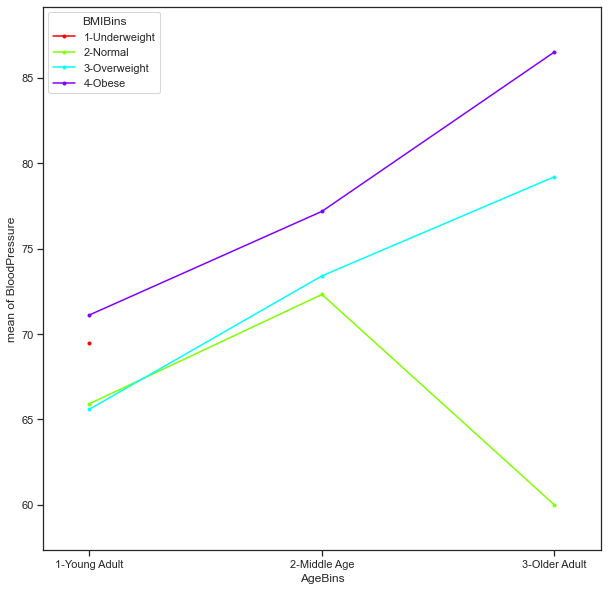

In [47]:
#Interaction Plot between Age and BMI as predictors of Blood Pressure
with mpl.rc_context():
    mpl.rc("figure", figsize=(10,10))
    interaction_plot(x=df['AgeBins'], trace=df['BMIBins'], response=df['BloodPressure'])

# ANCOVA

Comparing previously explored variable relations while accounting for covariances with glucose.

In [177]:
#Age with DPF covariate
pg.ancova(data=df, dv='BloodPressure', between='AgeBins', covar='Glucose')

Source            SS   DF          F         p-unc       np2
0   AgeBins   6874.113216    2  26.302072  8.979240e-12  0.064418
1   Glucose   2803.637219    1  21.454831  4.257455e-06  0.027315
2  Residual  99836.668223  764        NaN           NaN       NaN

In [178]:
import plotly.express as px
px.scatter(df, x='Glucose', y='BloodPressure',color='AgeBins')

In [179]:
#BMI with DPF covariate
pg.ancova(data=df, dv='BloodPressure', between='BMIBins', covar='Glucose')

Source             SS   DF          F         p-unc       np2
0   BMIBins    3647.801449    3   9.001850  7.294342e-06  0.034184
1   Glucose    3751.002952    1  27.769576  1.780041e-07  0.035117
2  Residual  103062.979990  763        NaN           NaN       NaN

In [180]:
px.scatter(df, x='Glucose', y='BloodPressure',color='BMIBins')

# Linear Regression

In [191]:
#Linearity Testing for Age
px.scatter(df, x='Age', y='BloodPressure',trendline="ols")

In [192]:
#Linearity Testing for Age
px.scatter(df, x='BMI', y='BloodPressure',trendline="ols")

In [48]:
#USING DUMMY VALUES
X = df[['AgeDums','BMIDums']]
y = df['BloodPressure']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(regressor.intercept_)
print(regressor.coef_)

#making predictions
y_pred = regressor.predict(X_test)
r2 = regressor.score(X, y)

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared:', r2)

53.5404848245179
[5.94461325 2.8755032 ]
Mean Absolute Error: 8.777682676115711
Mean Squared Error: 131.44183521973116
Root Mean Squared Error: 11.464808555738346
R-squared: 0.11964006559335005


In [49]:
#View coefficients better
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

Coefficient
AgeDums     5.944613
BMIDums     2.875503

In [50]:
#Making predictions
preds = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
preds.head()

Actual  Predicted
661    76.0  70.987111
122    74.0  70.987111
113    62.0  70.987111
14     72.0  74.056221
529    65.0  71.180718

In [81]:
#USING ORIGINAL VALUES
X = df[['Age','BMI']]
y = df['BloodPressure']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(regressor.intercept_)
print(regressor.coef_)

#making predictions
y_pred = regressor.predict(X_test)
r2 = regressor.score(X, y)

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared:', r2)

45.893297826162154
[0.31737325 0.49293738]
Mean Absolute Error: 8.560188259722757
Mean Squared Error: 127.39256897124068
Root Mean Squared Error: 11.28683166221773
R-squared: 0.18259175734127708


In [52]:
#Better view coefficients
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

Coefficient
Age     0.317373
BMI     0.492937

In [53]:
#Making predictions
preds = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
preds.head()

Actual  Predicted
661    76.0  74.022523
122    74.0  69.755579
113    62.0  70.587500
14     72.0  74.797118
529    65.0  67.858128